<a href="https://colab.research.google.com/github/otman-sarrhini/CTMouseBrainSegmentation/blob/main/Rat/04_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
Finally we are going to train our mouse brain segmentation network

## Imports:

* pathlib for easy path handling
* torch for tensor handling
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* imgaug for Data Augmentation
* numpy for file loading and array ops
* matplotlib for visualizing some images
* Our dataset and model



In [7]:
!pip install imgaug --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 15.0 MB/s 
     |████████████████████████████████| 512 kB 74.7 MB/s 
     |████████████████████████████████| 125 kB 56.7 MB/s 
     |████████████████████████████████| 87 kB 6.8 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=dc4554f36f51cf0ca7592a529fcf3d47d0016fc948bae58ec12d4173546b349d
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built fire


In [4]:
from google.colab import drive

drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [5]:
import os

os.chdir("/content/gdrive/MyDrive/Colab Notebooks/BrainCTSegmentationProject/Rats")

In [9]:
from dataset import BrainMaskDataset
from model import UNet

In [10]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping   # adding EarlyStopping 2022/12/02
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# ################### CODE FOR TESTING ONLY #############################
files = []
root = Path("/content/gdrive/MyDrive/Colab Notebooks/BrainCTSegmentationProject/Rats/Preprocessed/train")
for subject in root.glob("*"):   # Iterate over the subjects
  slice_path = subject/"data"  # Get the slices for current subject
  for slice in slice_path.glob("*.npy"):
    files.append(slice)
    break
  break

print(slice_path)
print(files)

/content/gdrive/MyDrive/Colab Notebooks/BrainCTSegmentationProject/Rats/Preprocessed/train/001/data
[PosixPath('/content/gdrive/MyDrive/Colab Notebooks/BrainCTSegmentationProject/Rats/Preprocessed/train/001/data/009.npy')]


## Dataset Creation
Here we create the train and validation dataset. <br />
Additionally, we define our data augmentation pipeline.
Subsequently the two dataloaders are created

In [ ]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [ ]:
# Create the dataset objects
train_path = Path("Preprocessed/train/")
val_path = Path("Preprocessed/val/")

train_dataset = BrainMaskDataset(train_path, seq)
val_dataset = BrainMaskDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 20460 train images and 3300 val images


In [ ]:
# ################### CODE FOR TESTING ONLY #############################
for slice, mask in train_dataset:
  assert slice.shape == (1, 288, 288)
  assert mask.shape == (1, 288, 288)
  break

print(slice.min(), slice.max())



(1, 288, 288) float32
(1, 288, 288) uint8


In [ ]:
# ################### CODE FOR TESTING ONLY #############################
for slice, mask in val_dataset:
  assert slice.shape == (1, 288, 288)
  assert mask.shape == (1, 288, 288)
  break

print(slice.min(), slice.max())


(1, 288, 288) float32
(1, 288, 288) uint8
0.0 0.25285354


In [ ]:
batch_size = 8
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [ ]:
# ################### CODE FOR TESTING ONLY #############################
for batch, (slice, mask) in enumerate(train_loader):
  break

print(slice.shape, mask.shape)

torch.Size([8, 1, 288, 288]) torch.Size([8, 1, 288, 288])


In [ ]:
# ################### CODE FOR TESTING ONLY #############################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# ################### CODE FOR TESTING ONLY #############################
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = DiceLoss()

optimizer.zero_grad()

mask = mask.float().to(device)
pred = model(slice.to(device))
        
loss = loss_fn(pred, mask)

print(loss.item())

1.0


In [ ]:
# ################### CODE FOR TESTING ONLY #############################
aa = loss.item()
np.abs(aa - 1) < np.finfo('float').eps

True

## Custom Loss
Often segmentation models perform better when using a Dice Loss instead of Cross-Entropy.<br />
The Dice Loss is defined as:
$$ L(\hat{y}, y) = 1-\frac{2 |\hat{y} \cap y|}{|\hat{y}| + |y|}$$

The intersection can be easily computed by $\hat{y}$ * $y$ as both variables are binary masks.

You can read more about the Dice Score here:
https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

In [14]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        # Flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()  # Numerator       
        denum = pred.sum() + mask.sum() + 1e-8  # Denominator. Add a small number to prevent NANS
        dice =  (2*counter)/denum
        return 1 - dice


## Full Segmentation Model

We will now combine everything into the full pytorch lightning model

In [12]:
class BrainMaskSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        pred = self(ct)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss)
        
        if batch_idx % 100 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        pred = self(ct)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss)
        
        if batch_idx % 10 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")
            
        return loss
    
    def log_images(self, ct, pred, mask, name):
        
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6, cmap='autumn')
        
        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [ ]:
# Instanciate the model and set the random seed
torch.manual_seed(0)
model = BrainMaskSegmentation()

In [ ]:
# Create the checkpoint callback
#checkpoint_callback = ModelCheckpoint(
#    monitor='Val Dice',
#    save_top_k=10,
#    mode='min')

checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=10,
    mode='min')

early_stop_callback = EarlyStopping(
    monitor='Val Dice',
    min_delta=1e-4,
    patience=3,
    verbose=False,
    mode="min")     # added 2022/12/02

In [ ]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

# gpus=gpus
gpus = 1 #TODO
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=TensorBoardLogger(save_dir="logs/"), log_every_n_steps=1,
                     callbacks=[checkpoint_callback, early_stop_callback],max_epochs=100)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [2]:
!pip install celluloid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Evaluation:
Let's evaluate the model

* nibabel to load a full scan
* tqdm for progress bar when validating the model
* celluloid for easy video generation


In [3]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera


First we load a checkpoint:

In [15]:
#model = AtriumSegmentation.load_from_checkpoint("weights/70.ckpt")
# model1 = BrainMaskSegmentation.load_from_checkpoint("logs/lightning_logs/version_1/checkpoints/epoch=74-step=177300.ckpt")
model1 = BrainMaskSegmentation.load_from_checkpoint("logs/lightning_logs/version_5/checkpoints/epoch=0-step=2558.ckpt")

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.eval();
model1.to(device);

In [17]:
# Create the dataset objects
val_path = Path("Preprocessed/val")

val_dataset = BrainMaskDataset(val_path, None)

print(f"There are {len(val_dataset)} val images")

There are 3300 val images


In [ ]:
print(f"There are {len(val_dataset)} val images")

There are 2740 val images


Evalute the complete validation dataset

In [18]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model1(slice)[0]
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/3300 [00:00<?, ?it/s]

In [19]:
print(f"labels shape: {labels.shape}, data type: {labels.dtype}")
print(f"preds shape: {preds.shape}, data type: {preds.dtype}")

labels shape: (3300, 1, 288, 288), data type: uint8
preds shape: (3300, 1, 288, 288), data type: float32


In [20]:
print(type(slice), type(label))

<class 'torch.Tensor'> <class 'numpy.ndarray'>


In [21]:
print(type(labels), type(preds))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Compute overall Dice Score (1- DiceLoss):
Wow! What a great score

In [22]:
1-model1.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))  # two possibilities

tensor(0.)

In [23]:
dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.0


In [24]:
dice_loss = DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).float())
print(f"The Val Dice Loss is: {dice_loss}")

The Val Dice Loss is: 1.0


## Visualization

We can now load a test subject from the dataset and estimate the position of the brain

In [ ]:
#subject = Path("/content/gdrive/Othercomputers/My_Laptop/GoogleDrive/Task02_Heart/imagesTs/la_002.nii.gz")
subject_path = Path("ImagesTs/image_093407.nii")
label_path = Path("LabelsTs/image_093407.nii")

ct = nib.load(subject_path).get_fdata().squeeze()
label = nib.load(label_path).get_fdata().astype(np.uint8).squeeze()

print(f'ct shape: {ct.shape}; label shape: {label.shape}')

ct shape: (512, 512, 512); label shape: (512, 512, 512)


(512, 512, 512)

As this scan is neither normalized nor standardized we need to perform those tasks!<br />
Let us copy the normalization and standardization functions from our preprocessing notebook:

In [ ]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


In [ ]:
# Crop the volume to the following values
sagittal_min = 153  # Should be 153
sagittal_max = 377  # 377

coronal_min = 173   # 173
coronal_max = 397   # 397

axial_min = 150
axial_max = 424

ct = ct[sagittal_min:sagittal_max, coronal_min:coronal_max, axial_min:axial_max]
label = label[sagittal_min:sagittal_max, coronal_min:coronal_max, axial_min:axial_max]

print(f'ct shape: {ct.shape}; label shape: {label.shape}')

ct shape: (224, 224, 274); label shape: (224, 224, 274)


In [ ]:
# Normalize and standardize the images
normalized_ct = normalize(ct)
standardized_ct = standardize(normalized_ct)

We preprocess the scan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning

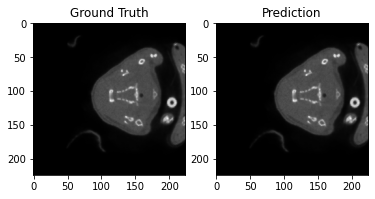

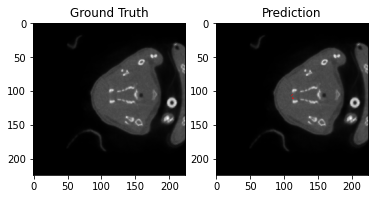

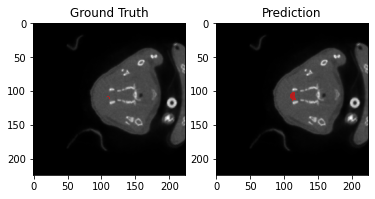

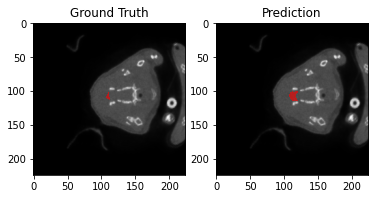

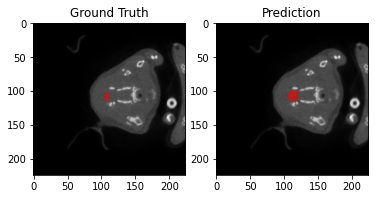

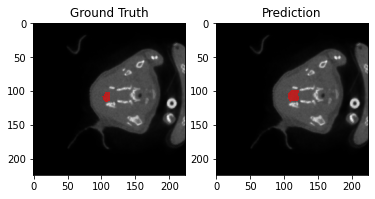

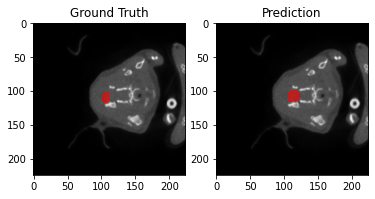

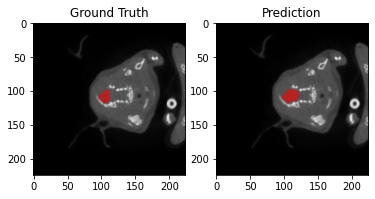

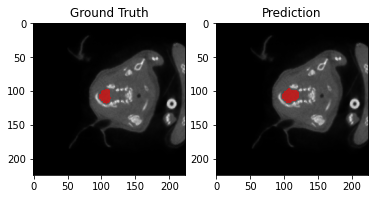

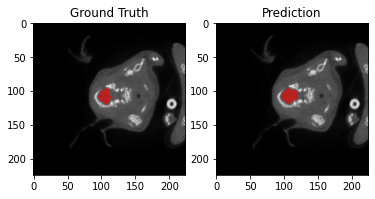

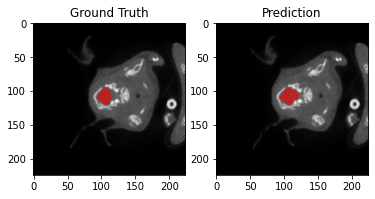

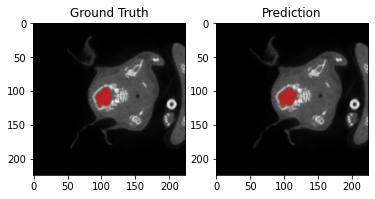

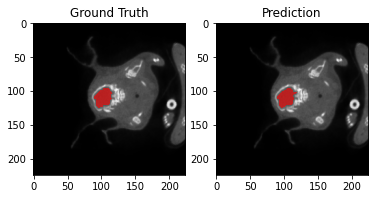

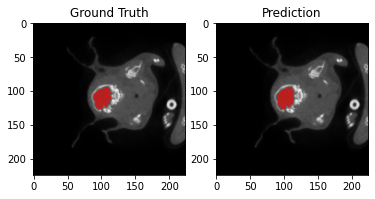

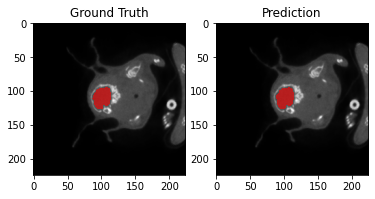

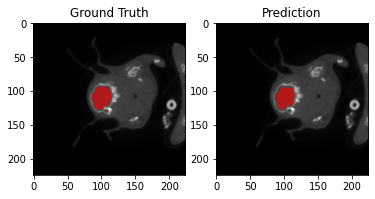

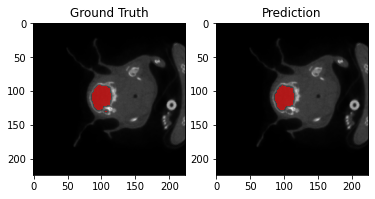

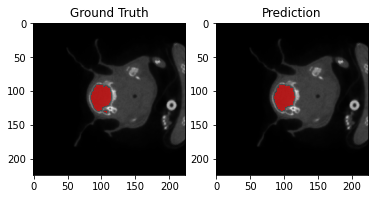

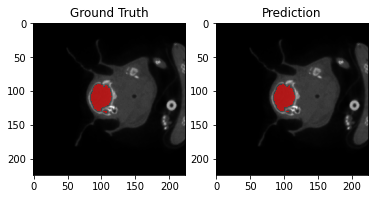

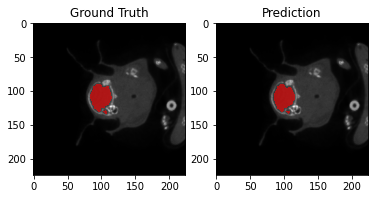

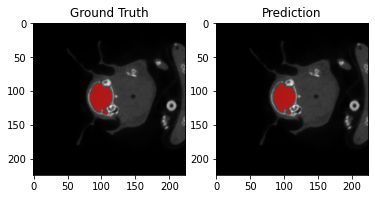

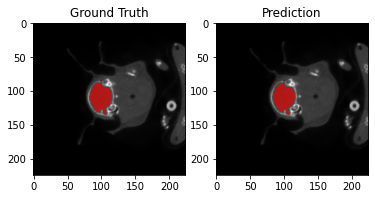

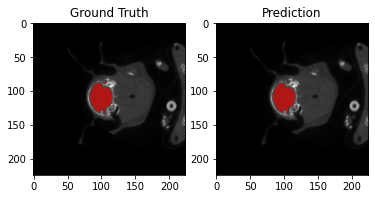

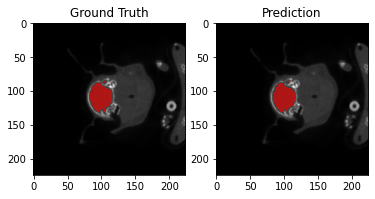

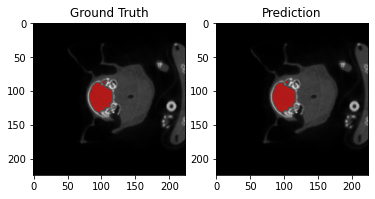

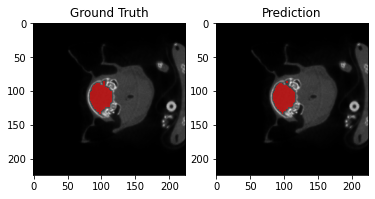

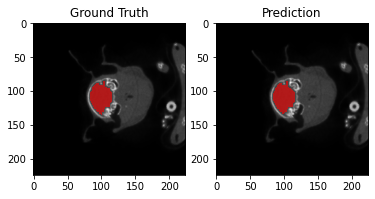

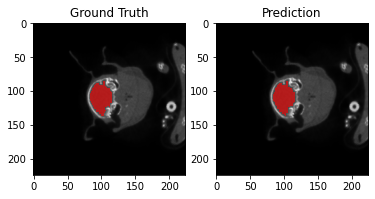

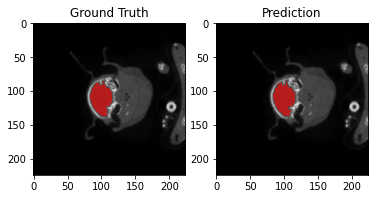

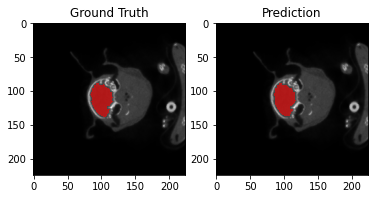

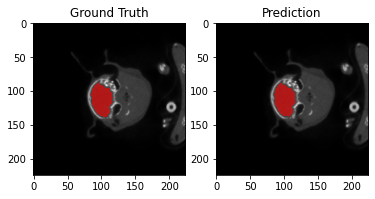

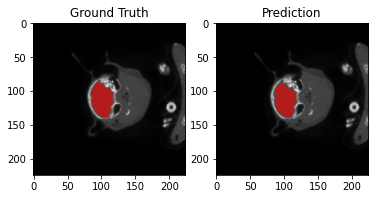

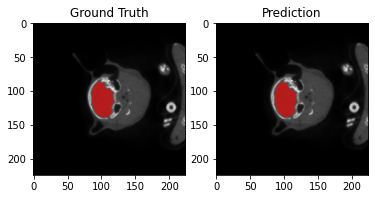

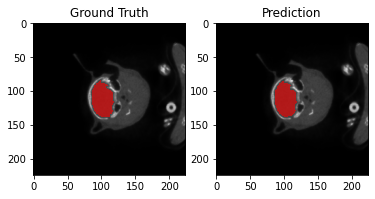

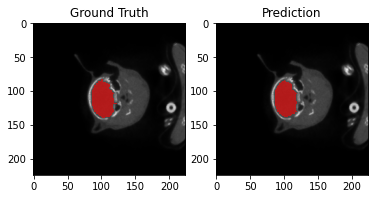

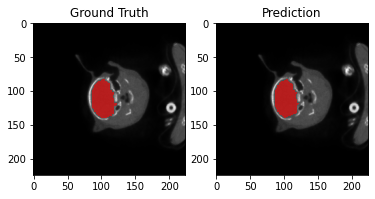

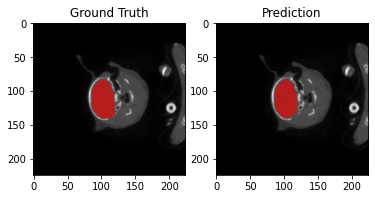

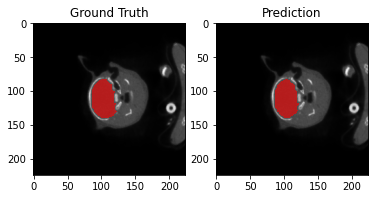

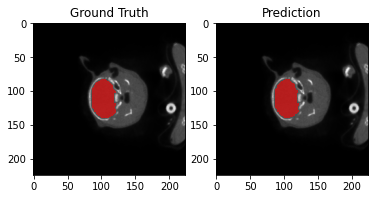

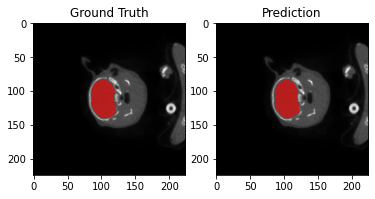

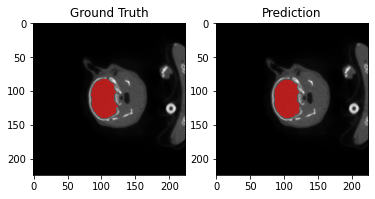

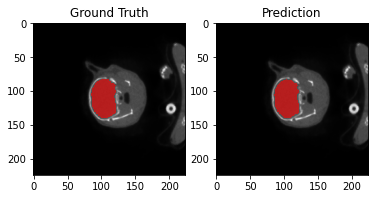

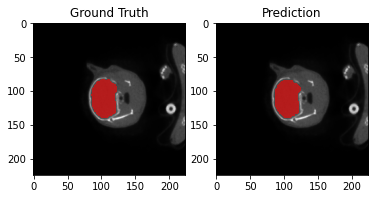

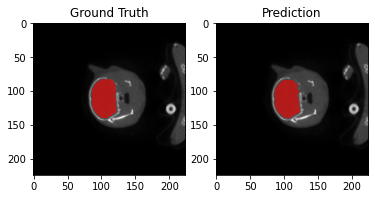

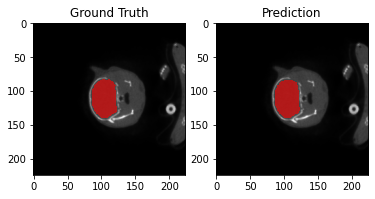

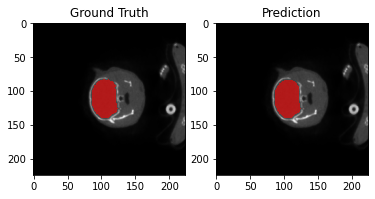

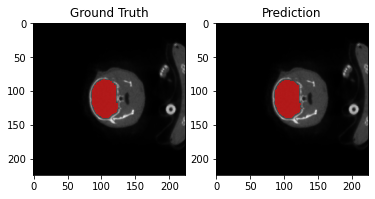

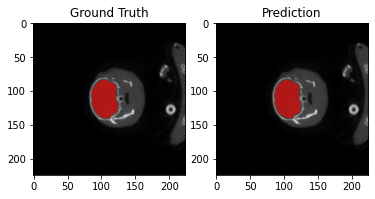

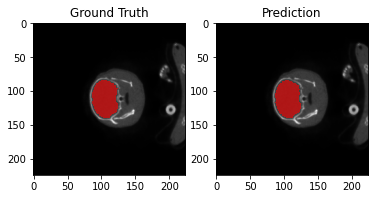

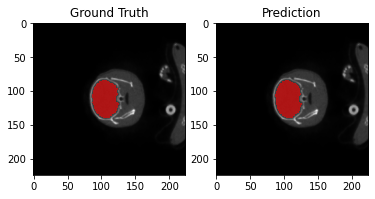

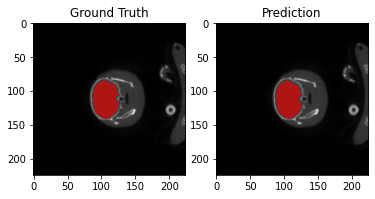

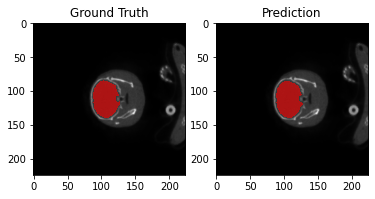

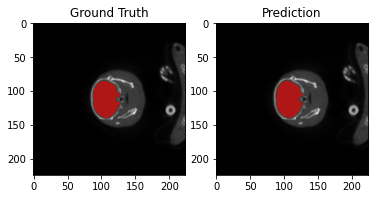

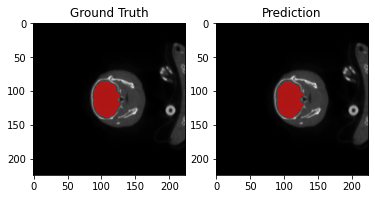

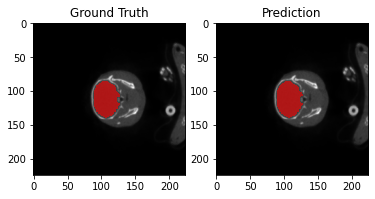

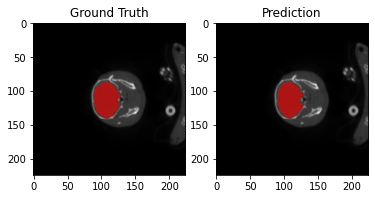

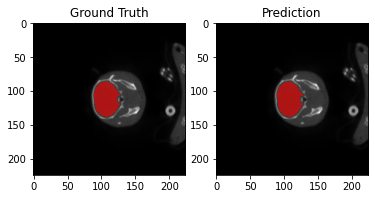

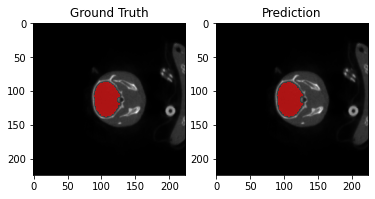

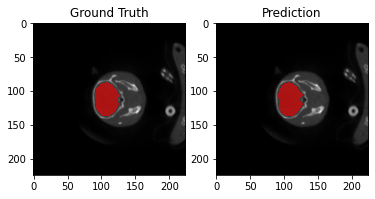

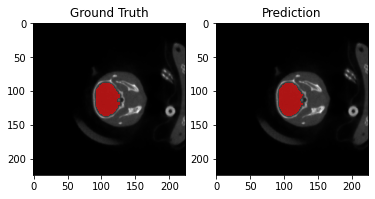

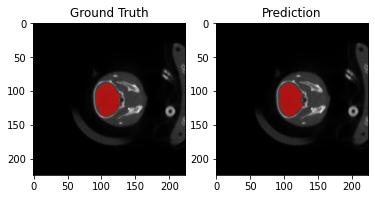

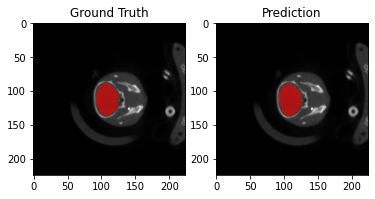

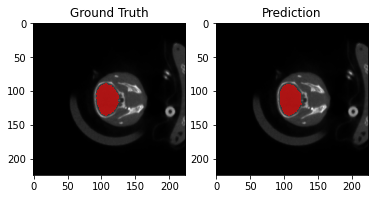

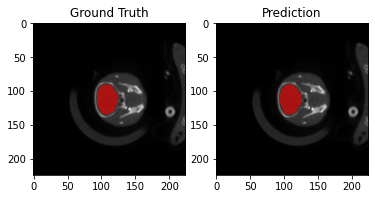

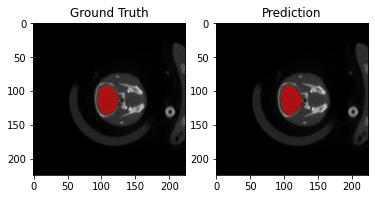

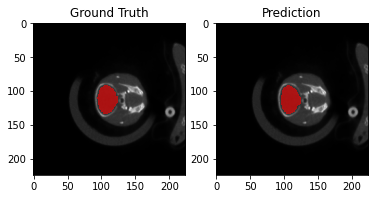

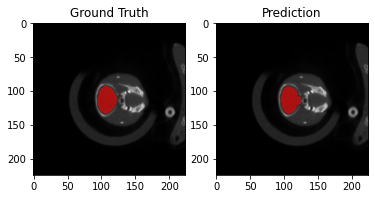

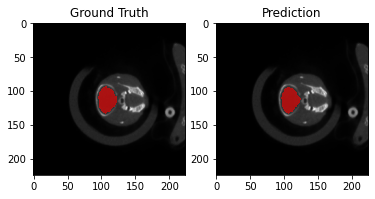

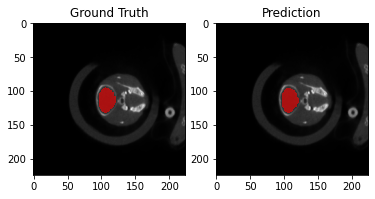

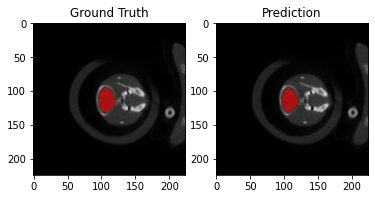

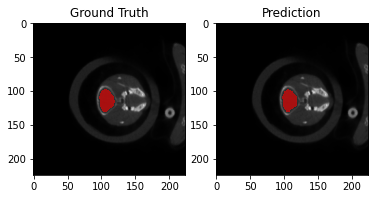

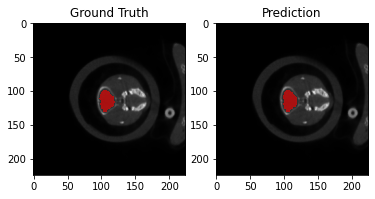

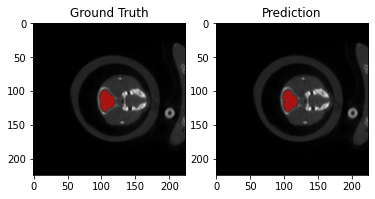

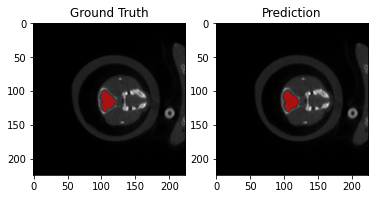

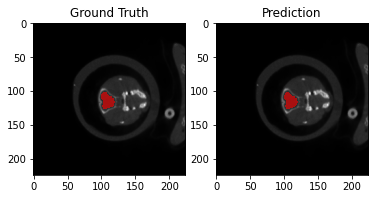

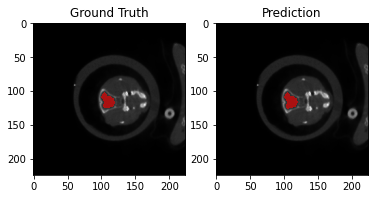

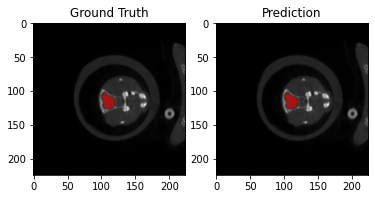

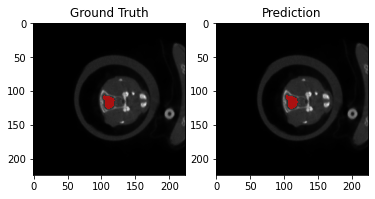

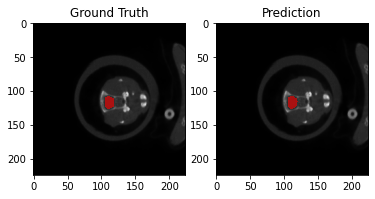

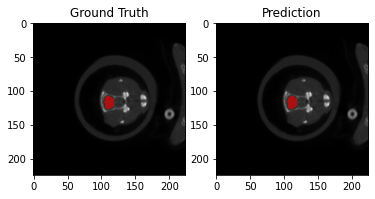

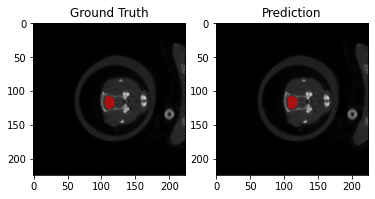

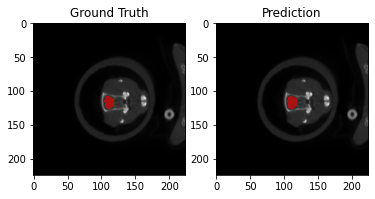

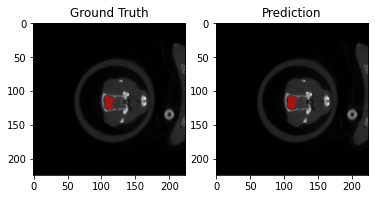

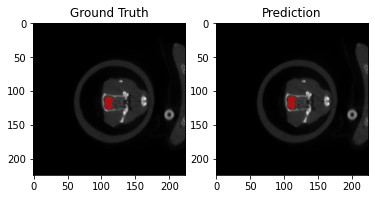

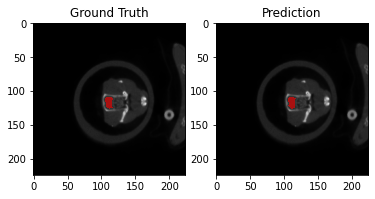

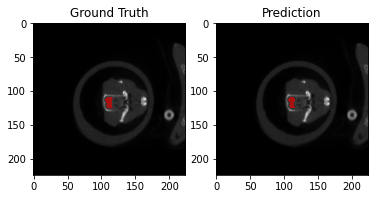

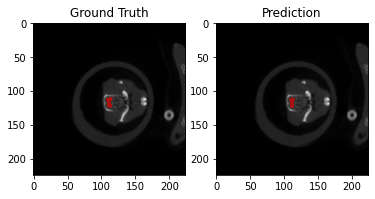

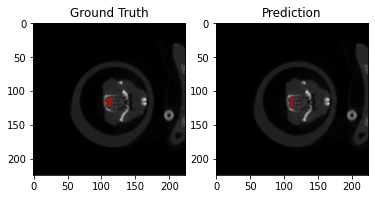

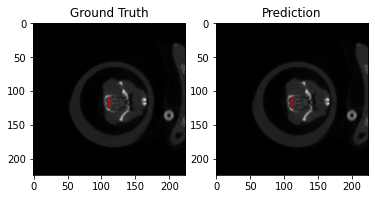

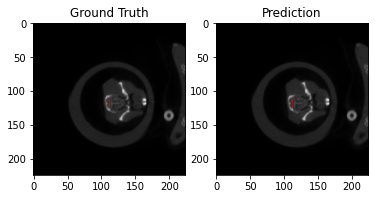

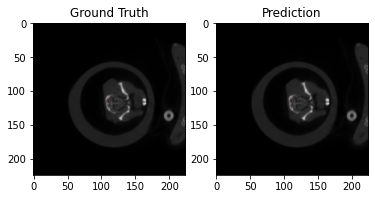

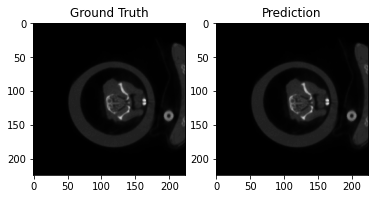

In [ ]:
preds = []
for i in range(standardized_ct.shape[-1]):
  current_slice = standardized_ct[:, :, i]
  current_label = label[:, :, i]

  with torch.no_grad():
    pred = model1(torch.tensor(current_slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
    pred = pred.cpu().numpy() > 0.5
    preds.append(pred)

  if np.any(current_label):
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(current_slice, cmap='gray')
    mask_ = np.ma.masked_where(current_label == 0, current_label)
    axis[0].imshow(mask_, alpha=0.6, cmap='autumn')
    axis[0].set_title('Ground Truth')

    axis[1].imshow(current_slice, cmap='gray')
    mask_ = np.ma.masked_where(pred == 0, pred)
    axis[1].imshow(mask_, alpha=0.6, cmap='autumn')
    axis[1].set_title('Prediction')

In [ ]:
preds = np.array(preds)

preds.dtype

dtype('bool')

In [ ]:
preds = preds.astype(np.uint8)
preds.dtype

dtype('uint8')

In [ ]:

#aa = np.ones((8, 12))
#bb = aa[2:5, 3:10]
#cc = np.pad(bb, ((2, 3), (3, 2)), 'constant')

preds_t = np.transpose(preds,(1, 2, 0))
mask_result = np.pad(
    preds_t, 
    (
        (sagittal_min, 512-sagittal_max), 
        (coronal_min, 512-coronal_max),
        (axial_min, 512 - axial_max)
    ), 
    'constant'
)

mask_result.shape

(512, 512, 512)

In [ ]:
preds.shape

(274, 224, 224)

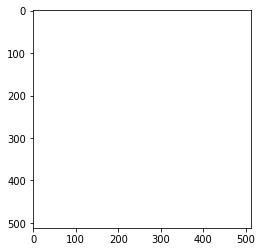

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(mask_result.shape[-1]):
    plt.imshow(mask_result[:,:,i], cmap="bone")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation


In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video

In [ ]:
# Write the mask_result to NIfti file
nii_result = nib.Nifti1Image(mask_result, nib.load(label_path).affine)

nib.save(nii_result, Path("LabelsTs/image_093407_DL.nii"))

# Test on another image

## 1: Load test image

In [ ]:
# Paths definition
subject_path = Path("ImagesTs/image_113934.nii")
label_path = Path("LabelsTs/image_113934.nii")

# Load image and label
nii_ct = nib.load(subject_path)
nii_label = nib.load(label_path)

ct_image = nii_ct.get_fdata().squeeze()
label_image = nii_label.get_fdata().astype(np.uint8).squeeze()

# Check the image and label orientation
assert nib.aff2axcodes(nii_ct.affine) == ('R', 'A', 'S')
assert nib.aff2axcodes(nii_label.affine) == ('R', 'A', 'S')

# Check if image and label have the same size
assert ct_image.shape == label_image.shape

# Define the vues dimensions
sagittal_dim, coronal_dim, axial_dim = ct_image.shape

print(f'image shape {ct_image.shape}')



image shape (512, 512, 512)


## 2. Preprocessing (crop, normalize and standarize)

In [ ]:
# Crop image and label to the size used to train images
# Crop the volume to the following values
sagittal_min = 153  # Should be 153
sagittal_max = 377  # 377

coronal_min = 173   # 173
coronal_max = 397   # 397

axial_min = 150
axial_max = 424

ct_image = ct_image[sagittal_min:sagittal_max, coronal_min:coronal_max, axial_min:axial_max]
label_image = label_image[sagittal_min:sagittal_max, coronal_min:coronal_max, axial_min:axial_max]

ct_image = standardize(normalize(ct_image))

# Check the preprocessed image and label shape
assert ct_image.shape == (224, 224, 274)
assert label_image.shape == (224, 224, 274)


## 3. Process the current scan using the last Epoch checkpoint

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: conv

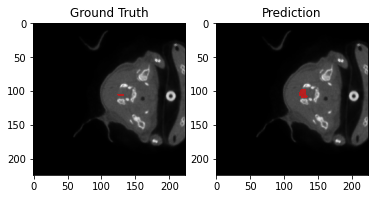

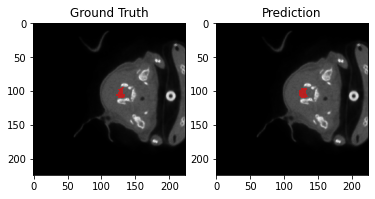

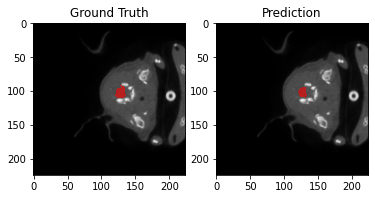

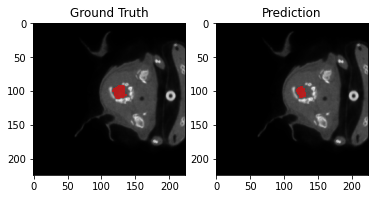

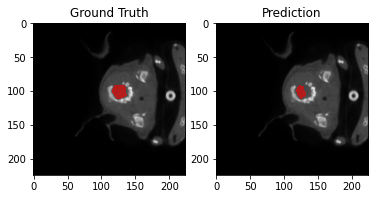

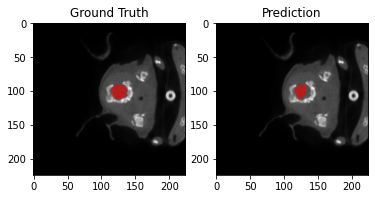

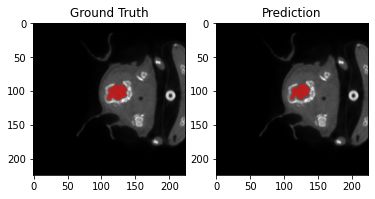

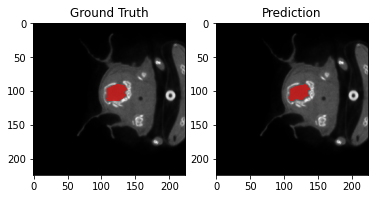

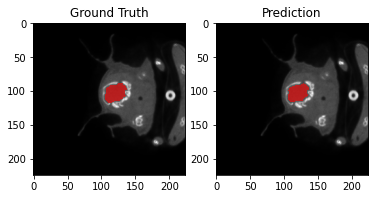

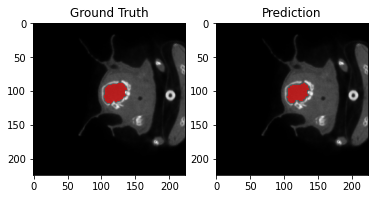

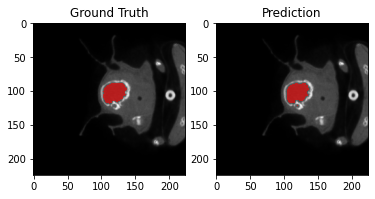

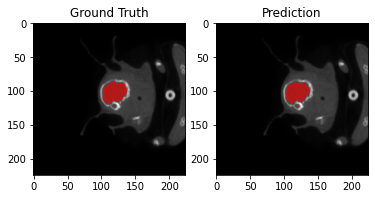

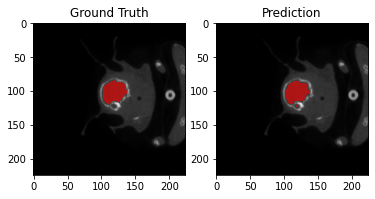

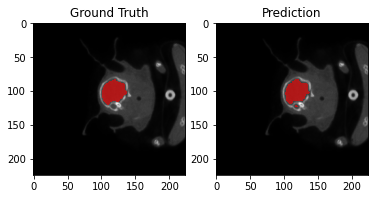

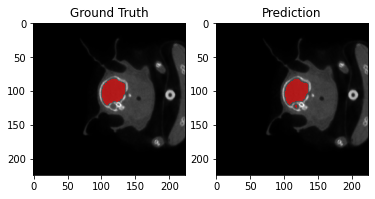

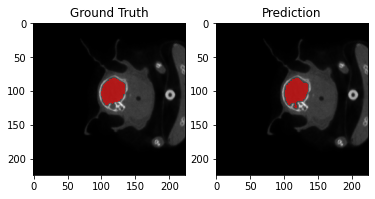

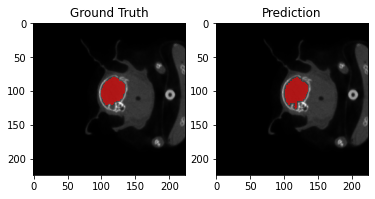

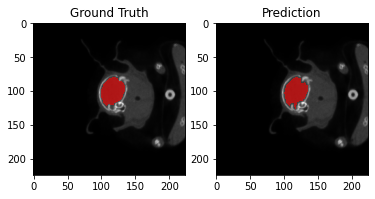

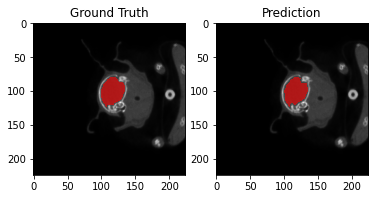

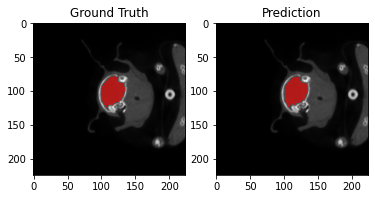

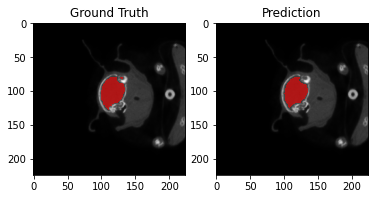

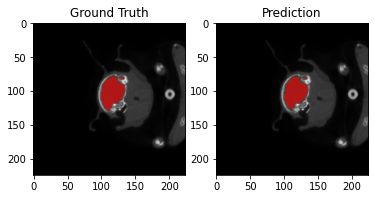

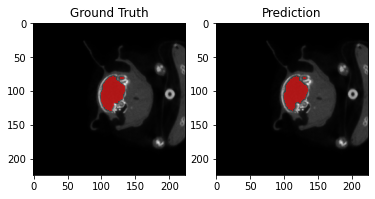

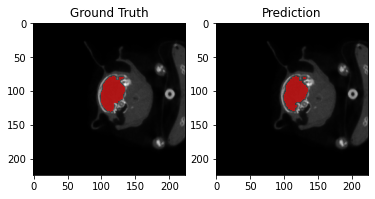

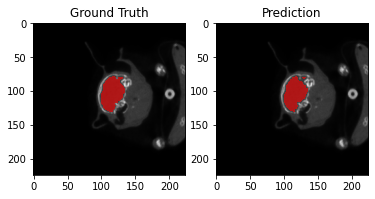

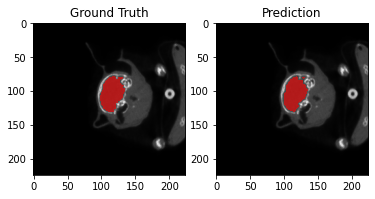

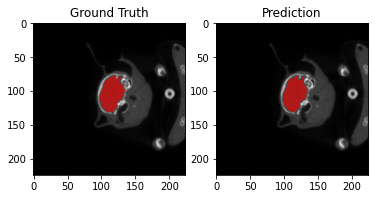

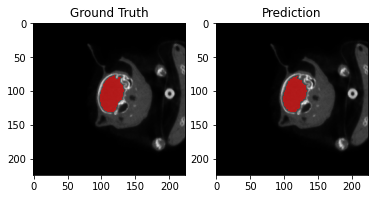

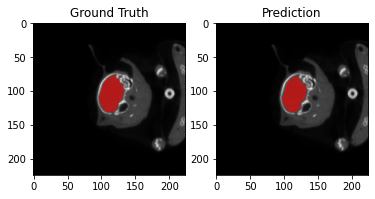

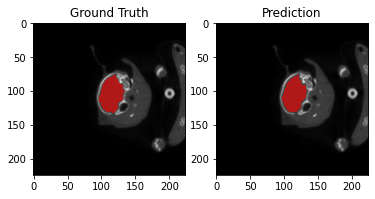

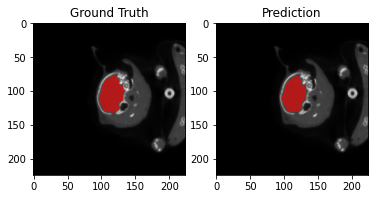

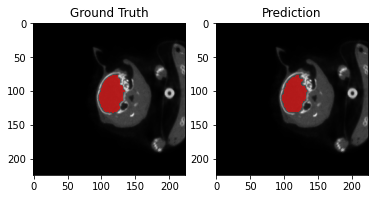

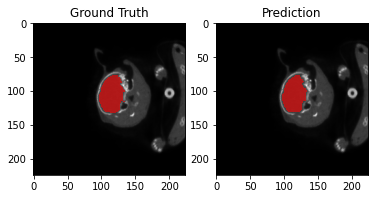

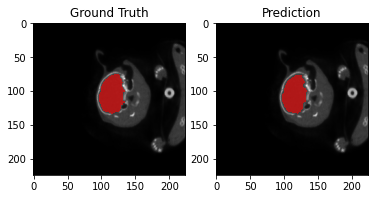

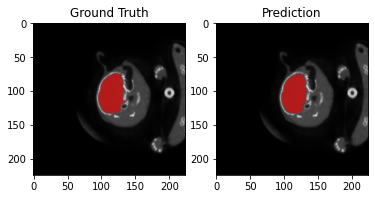

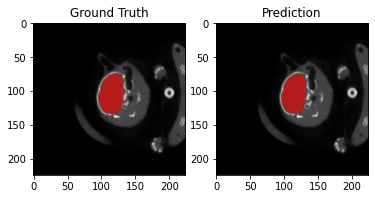

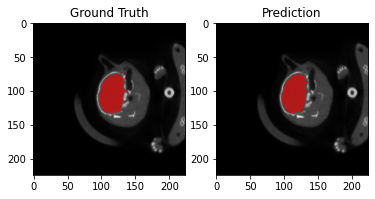

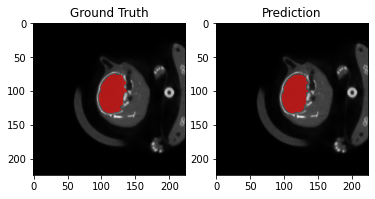

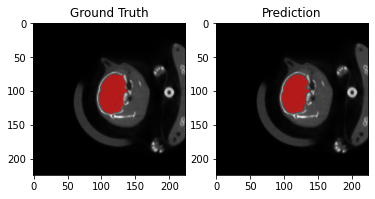

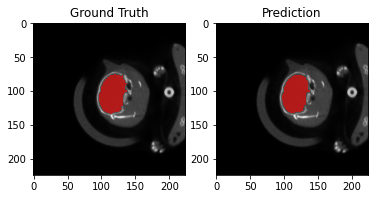

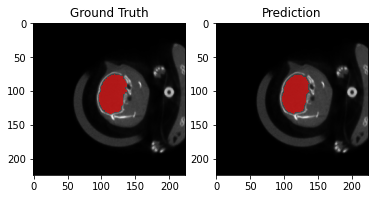

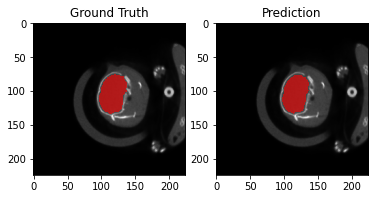

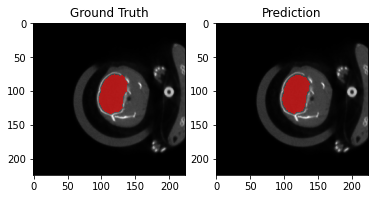

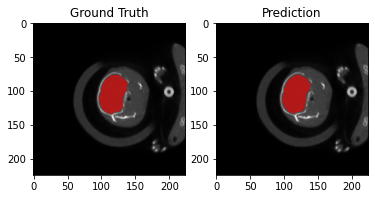

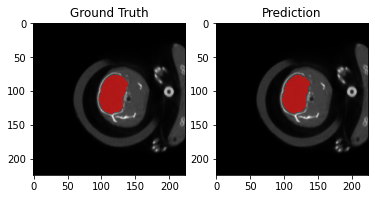

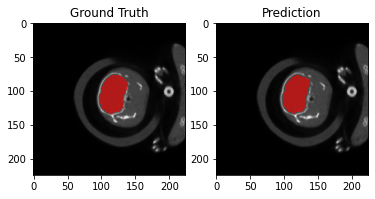

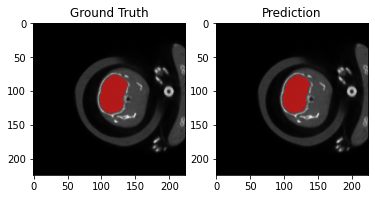

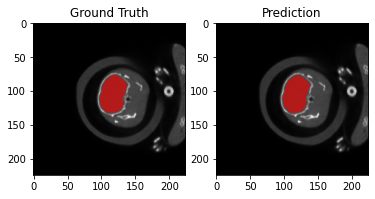

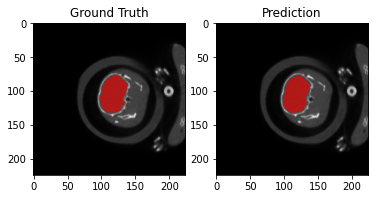

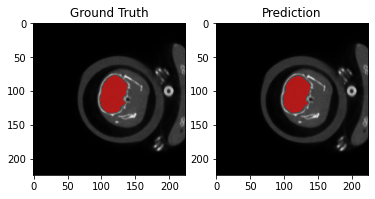

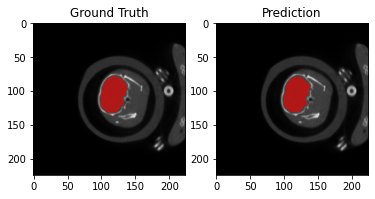

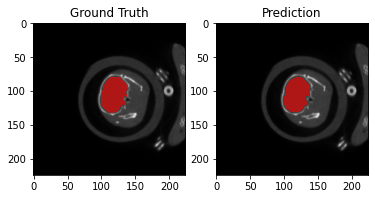

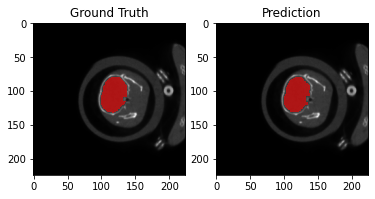

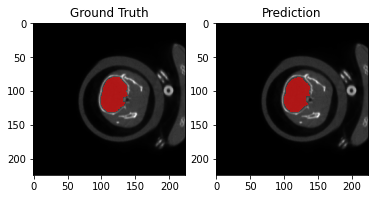

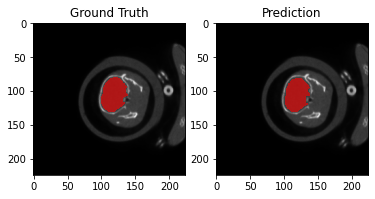

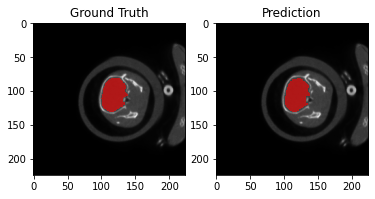

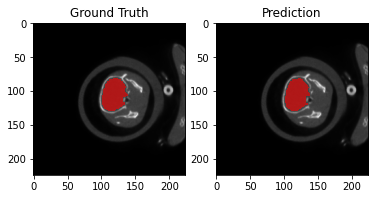

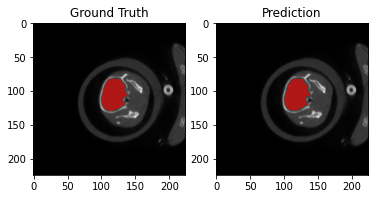

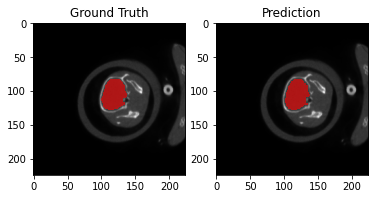

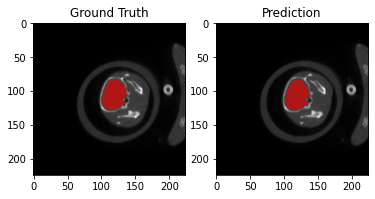

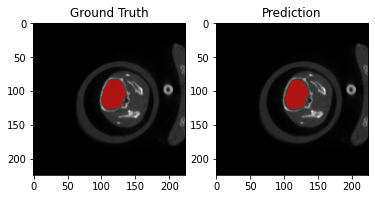

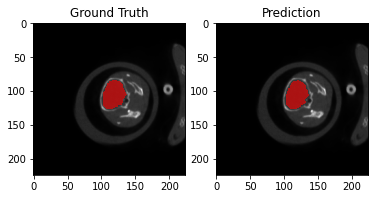

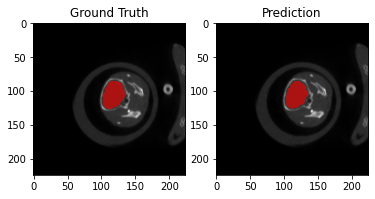

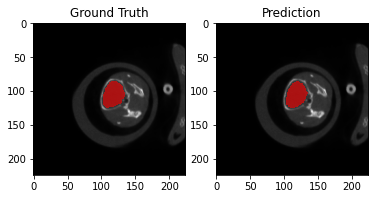

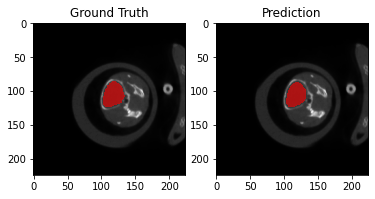

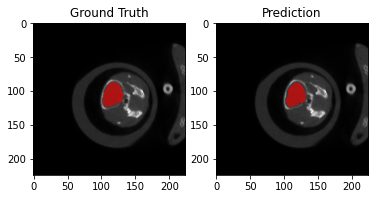

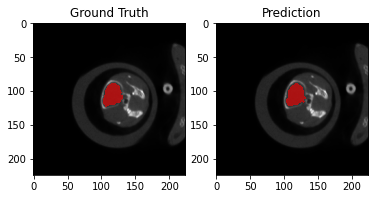

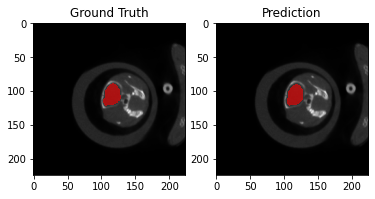

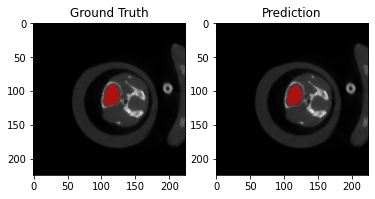

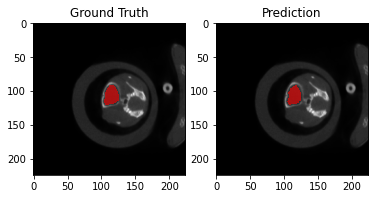

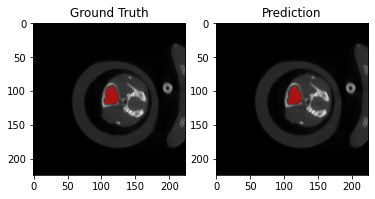

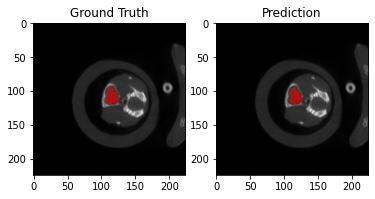

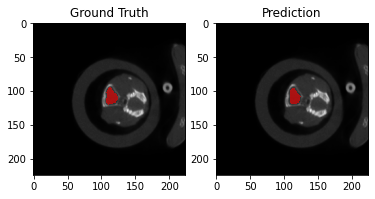

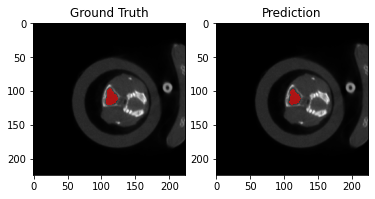

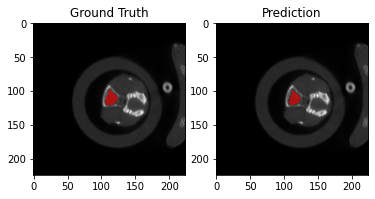

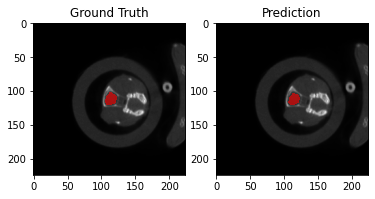

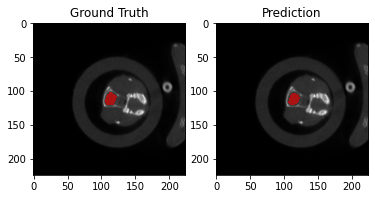

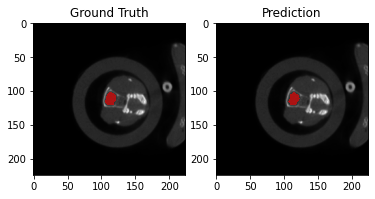

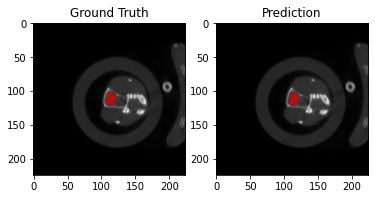

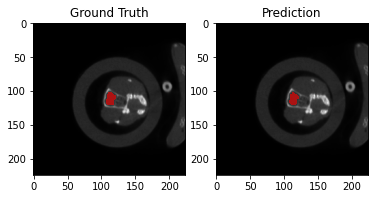

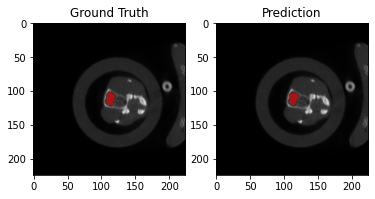

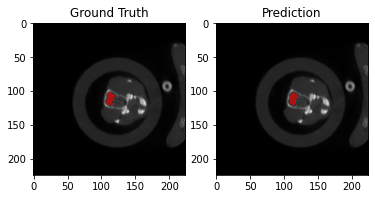

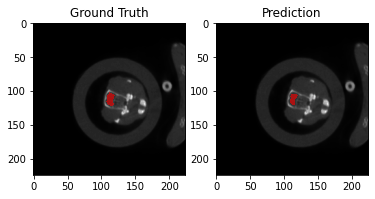

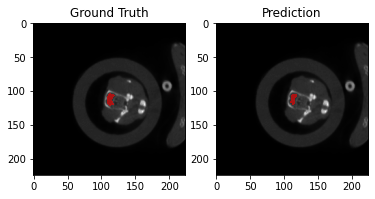

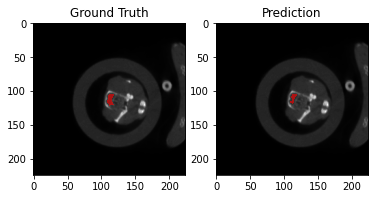

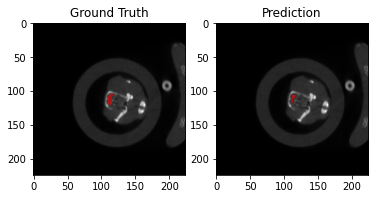

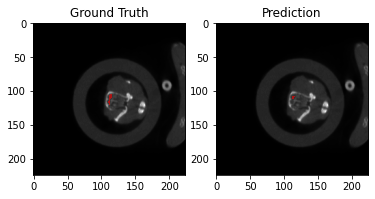

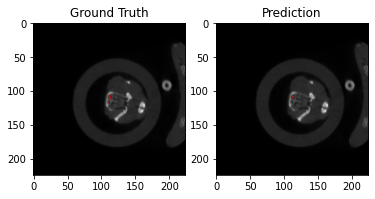

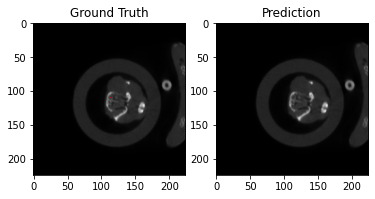

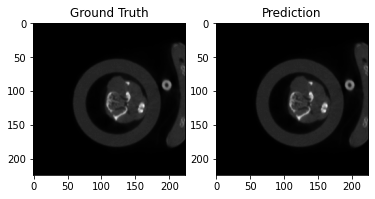

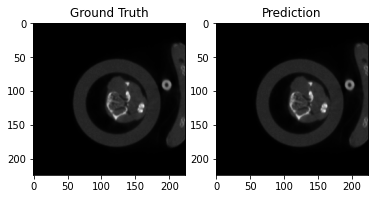

In [ ]:
preds = []
for i in range(ct_image.shape[-1]):
  current_slice = ct_image[:, :, i]
  current_label = label_image[:, :, i]

  with torch.no_grad():
    pred = model1(torch.tensor(current_slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
    pred = pred.cpu().numpy() > 0.5
    preds.append(pred.astype(np.uint8))

  # show only labled slices
  if np.any(current_label):
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(current_slice, cmap='gray')
    mask_ = np.ma.masked_where(current_label == 0, current_label)
    axis[0].imshow(mask_, alpha=0.6, cmap='autumn')
    axis[0].set_title('Ground Truth')

    axis[1].imshow(current_slice, cmap='gray')
    mask_ = np.ma.masked_where(pred == 0, pred)
    axis[1].imshow(mask_, alpha=0.6, cmap='autumn')
    axis[1].set_title('Prediction')

preds = np.array(preds)
preds = np.transpose(preds, (1, 2, 0))

# Pad with zeros to get the original label size
mask_result = np.pad(
    preds, 
    (
        (sagittal_min, sagittal_dim-sagittal_max), 
        (coronal_min, coronal_dim-coronal_max),
        (axial_min, axial_dim - axial_max)
    ), 
    'constant'
)

# Write the mask_result to NIfti file
fnout = str(label_path)
fnout = fnout[0:fnout.index('.nii')] + "_DL.nii"

nii_result = nib.Nifti1Image(mask_result, nii_label.affine)
nib.save(nii_result, Path(fnout))

In [ ]:
fnout = str(label_path)
fnout = fnout[0:fnout.index('.nii')] + "_DL.nii"
fnout

'LabelsTs/image_113934_DL.nii'

In [ ]:
str(label_path)

'LabelsTs/image_113934.nii'

In [ ]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:,:,i]
    with torch.no_grad():
        pred = model1(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


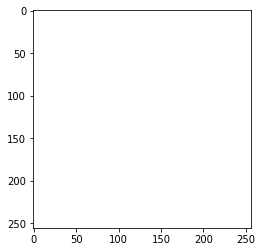

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    if preds[i].sum() > 0:
      mask = np.ma.masked_where(preds[i]==0, preds[i])
      plt.imshow(mask, alpha=0.5, cmap="autumn")
    
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video


Congratulations! You made it to the end of the segmentation lecture